# 'Flattening the curve' optimisation on an SIR model using JuMP.jl 

Initial version [here](https://github.com/epirecipes/sir-julia/blob/master/markdown/function_map_ftc_jump/function_map_ftc_jump.md) by Simon Frost (@sdwfrost)\
Current version Sandra Montes (@slmontes), 2025-03-10

## Introduction

This example explores the optimal control of an SIR (Susceptible-Infected-Recovered) model using a time-varying intervention that reduces the infection rate, similar to the lockdown example. 

The following differential equations also describe this model :

$$
\begin{aligned}
\dfrac{\mathrm{d}S}{\mathrm{dt}} &= -\beta (1 - \upsilon(t)) S I, \\
\dfrac{\mathrm{d}I}{\mathrm{dt}} &= \beta (1 - \upsilon(t)) S I - \gamma I, \\
\dfrac{\mathrm{d}C}{\mathrm{dt}} &= \beta (1 - \upsilon(t)) S I,
\end{aligned}
$$

In this case, the optimal control problem is formulated to minimise the total intervention cost, measured as the integral of `υ(t)` over time while ensuring that the number of infected individuals, `I`, stays below a set threshold `I_max`. This constraint is introduced to achieve the objective of 'flattening the curve,' meaning that the optimal intervention policy `υ(t)` balances the cost of intervention with the need to keep the infection spread manageable, ensuring that the number of infected individuals never exceeds the threshold `I_max`. Again, we determine the optimal policy numerically using a simple Euler discretisation and then JuMP.jl with IPOPT to optimise.

## Libraries

In [1]:
using OrdinaryDiffEq
using DiffEqCallbacks
using JuMP
using Ipopt
using Plots
using DataInterpolations
using NonlinearSolve;

## Functions

ODE system

In [2]:
function sir_ode!(du,u,p,t)
    (S, I, C) = u
    (β, γ, υ) = p
    @inbounds begin
        du[1] = -β*(1-υ)*S*I
        du[2] = β*(1-υ)*S*I - γ*I
        du[3] = β*(1-υ)*S*I
    end
    nothing
end;

## Running the model without intervention

Parameters

In [3]:
u0 = [0.99, 0.01, 0.0]; #S, I, C (cumulative incidence)
p = [0.5, 0.25, 0]; # β, γ, υ

In [4]:
t0 = 0.0
tf = 100
dt = 0.1
ts = collect(t0:dt:tf)
alg = Tsit5();

Solve using ODEProblem

In [5]:
prob1 = ODEProblem(sir_ode!, u0, (t0, tf), p)
sol1 = solve(prob1, alg, saveat=ts);

Without control the peak fraction of infected individuals is:

In [6]:
peak_value, peak_index = findmax(sol1[2, :]) 
println("The maximum fraction of infected at a `dt` time is: ", peak_value)

The maximum fraction of infected at a `dt` time is: 0.15845528864496652


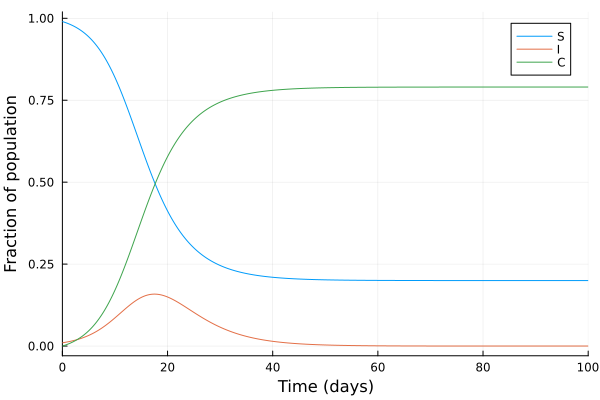

In [7]:
plot(sol1,
     xlim=(0, 100),
     labels=["S" "I" "C"],
     xlabel="Time (days)",
     ylabel="Fraction of population")

## Searching for the optimal intervention constrained by `I_max`

Parameters

In [8]:
p2 = copy(p)
p2[3] = 0.5;   #Set υ to 0.5
β = p2[1]
γ = p2[2]
υ_max = p2[3]
I_max = 0.1

S0 = u0[1]
I0 = u0[2]
C0 = u0[3]

T = Int(tf/dt)

silent = true;

Model setup

In [9]:
model = Model(Ipopt.Optimizer)
set_optimizer_attribute(model, "max_iter", 1000)
if !silent
    set_optimizer_attribute(model, "output_file", "JuMP_ftc.txt")
    set_optimizer_attribute(model, "print_timing_statistics", "yes")
end;

Variables:

We declare the number of timesteps, `T`, and vectors of our model variables, including the intervention level, `ν`,  each `T+1` step long. We also define the total cost of the intervention, `υ_total` as a variable. From their definition, the variables `S` and `C` are constrained to values between 0 and 1. While the variables  `I` and `υ` are constrained to values between 0 and their respective maximum value previously defined.

In [10]:
@variable(model, 0 <= S[1:(T+1)] <= 1)
@variable(model, 0 <= I[1:(T+1)] <= I_max)
@variable(model, 0 <= C[1:(T+1)] <= 1)
@variable(model, 0 <= υ[1:(T+1)] <= υ_max)
@variable(model, υ_total);

We discretise the SIR model using a simple Euler discretisation:

In [11]:
@expressions(model, begin
        infection[t in 1:T], (1 - υ[t]) * β * I[t] * dt * S[t]  # Linear approximation of infection rate
        recovery[t in 1:T], γ * dt * I[t] # Recoveries at each time step
    end);

We constrain our model so the integral of the intervention is equal to `υ_total`, assuming that the intervention is piecewise constant during each time step.

In [12]:
@constraints(model, begin
    S[1]==S0
    I[1]==I0
    C[1]==C0
    [t=1:T], S[t+1] == S[t] - infection[t]
    [t=1:T], I[t+1] == I[t] + infection[t] - recovery[t]
    [t=1:T], C[t+1] == C[t] + infection[t]
    dt * sum(υ[t] for t in 1:T+1) == υ_total
end);

This scenario's objective is to minimise the total cost of intervention instead of the cumulative incidence, as in the previous single lockdown scenario.

In [13]:
@objective(model, Min, υ_total);

In [14]:
if silent
    set_silent(model)
end
optimize!(model)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [15]:
termination_status(model)

LOCALLY_SOLVED::TerminationStatusCode = 4

In [16]:
S_opt = value.(S)
I_opt = value.(I)
C_opt = value.(C)
υ_opt = value.(υ);

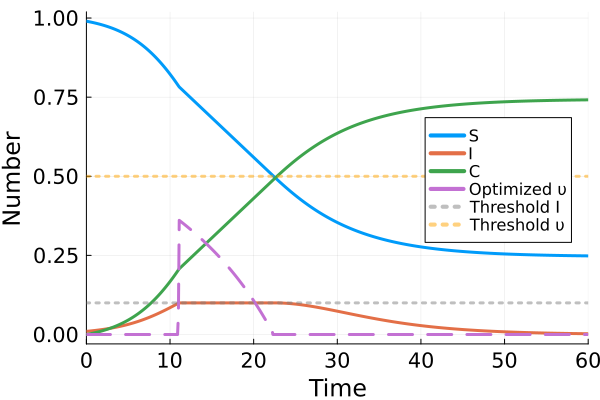

In [30]:
plot(ts, S_opt, label="S", xlabel="Time", ylabel="Number", legend=:right, xlim=(0,60),
linewidth=3, xtickfontsize=14, ytickfontsize=14, xguidefontsize=16, yguidefontsize=16,legendfontsize=11)
plot!(ts, I_opt, label="I", linewidth=3)
plot!(ts, C_opt, label="C", linewidth=3)
plot!(ts, υ_opt, label="Optimized υ", linewidth=3, linestyle=:dash)
hline!([I_max], color=:gray, alpha=0.5, label="Threshold I", linewidth=3, linestyle=:dot)
hline!([υ_max], color=:orange, alpha=0.5, label="Threshold υ", linewidth=3, linestyle=:dot)
# savefig("case2_plot.png")

With the optimised intervention, we can confirm that the maximum number of fraction of infected does not exceed `I_max`:

In [19]:
peak_value_opt, peak_index_opt = findmax(I_opt) 
println("The maximum fraction of infected at a `dt` time is: ", peak_value_opt)

The maximum fraction of infected at a `dt` time is: 0.1000000099370598


Again, we can calculate the effective reproductive number, `Rₜ′` in the presence of the intervention:

In [20]:
Rₜ_opt = β.* S_opt ./γ   #Not taking into account the intervention
Rₜ′_opt = Rₜ_opt .* (1 .- υ_opt);  #Taking into account the intervention

And the time at which `Rₜ==1` using a root-finding approach:

In [21]:
Rₜ_interp = CubicSpline(Rₜ_opt,ts)
f(u, p) = [Rₜ_interp(u[1]) - 1.0]
u0 = [(tf-t0)/3]
Rtprob = NonlinearProblem(f, u0)
Rtsol = solve(Rtprob, NewtonRaphson(), abstol = 1e-9).u[1];

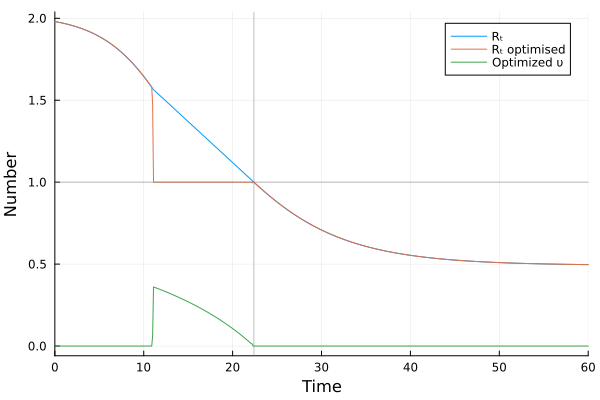

In [22]:
plot(ts, Rₜ_opt, label="Rₜ", xlabel="Time", ylabel="Number", legend=:topright, xlim=(0,60))
plot!(ts, Rₜ′_opt, label="Rₜ optimised")
plot!(ts, υ_opt, label="Optimized υ")
vline!([Rtsol], color=:gray, alpha=0.5, label=false)
hline!([1.0], color=:gray, alpha=0.5, label=false)

## Discussion

The optimal policy obtained involves a single lockdown that increases rapidly at or shortly before the infected population reaches its threshold level. Once this threshold is reached, the intensity of the lockdown is gradually reduced. We can view the total cost as the area under the policy curve.

The plot of `Rₜ` over time shows that the intervention targets `Rₜ=1` (including intervention) at the threshold level of infected individuals and that the lockdown stops when `Rₜ==1` in the absence of an intervention, ensuring that the population of infected individuals does not increase.

Compared to a model designed to minimise the total number of infections, the current strategy that keeps the infected population below a certain threshold while minimising intervention costs also leads to a single intervention period. However, in this case, the strength of the intervention decreases over time.

It is important to mention that there are significant challenges in translating this finding into actual intervention policies. Fine-tuning the intensity of the intervention over time may not be feasible; instead, a series of staged interventions with varying intensities might be necessary. The impact of the intervention may be uncertain prior to implementation, and if the efficacy is lower, it may require initiating the intervention well in advance before reaching the infected threshold. Additionally, determining when to stop the intervention requires knowledge of the effective reproduction number (the 'R number') in the absence of the intervention. This requires reliable estimates of `Rₜ` and the intensity of the intervention, `υ`. These uncertainties are in addition to the usual uncertainty in model structure and parameter values of the underlying model.